In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:

import numpy as np
import pandas as pd
import pickle
import numpy as np
import random
import time
import os
#os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,40).__str__()
import cv2
from tqdm import tqdm

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from keras import optimizers
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
dataset_dir = "drive/My Drive/HAM10000/HAM10000_Gray_Categorized_train_Upsampled/"
work_dir = "drive/My Drive/HAM10000/"

In [4]:
list_categories = ['akiec','bcc','bkl','df','mel','nv','vasc']
num_classes = len(list_categories)
print('num_classes =', num_classes)

num_classes = 7


In [5]:
# Saving files:
'''
np.save(work_dir+"np_test_imageset.pkl", np_test_imageset, allow_pickle=True)
np.save(work_dir+"np_val_imageset.pkl", np_val_imageset, allow_pickle=True)
np.save(work_dir+"np_train_imageset.pkl", np_train_imageset, allow_pickle=True)

np.save(work_dir+"np_test_label.pkl", np_test_label, allow_pickle=True)
np.save(work_dir+"np_val_label.pkl", np_val_label, allow_pickle=True)
np.save(work_dir+"np_train_label.pkl", np_train_label, allow_pickle=True)
#'''

'\nnp.save(work_dir+"np_test_imageset.pkl", np_test_imageset, allow_pickle=True)\nnp.save(work_dir+"np_val_imageset.pkl", np_val_imageset, allow_pickle=True)\nnp.save(work_dir+"np_train_imageset.pkl", np_train_imageset, allow_pickle=True)\n\nnp.save(work_dir+"np_test_label.pkl", np_test_label, allow_pickle=True)\nnp.save(work_dir+"np_val_label.pkl", np_val_label, allow_pickle=True)\nnp.save(work_dir+"np_train_label.pkl", np_train_label, allow_pickle=True)\n#'

In [6]:
# Loading files:
np_test_imageset = np.load(dataset_dir+"HAM10000_Gray_Categorized_train_Upsampled_128x128_norm_test_X.pkl.npy", allow_pickle=True)
np_val_imageset = np.load(dataset_dir+"HAM10000_Gray_Categorized_train_Upsampled_128x128_norm_val_X.pkl.npy", allow_pickle=True)
np_train_imageset = np.load(dataset_dir+"HAM10000_Gray_Categorized_train_Upsampled_128x128_norm_train_X.pkl.npy", allow_pickle=True)

np_test_label = np.load(dataset_dir+"HAM10000_Gray_Categorized_train_Upsampled_128x128_test_Y.pkl.npy", allow_pickle=True)
np_val_label = np.load(dataset_dir+"HAM10000_Gray_Categorized_train_Upsampled_128x128_val_Y.pkl.npy", allow_pickle=True)
np_train_label = np.load(dataset_dir+"HAM10000_Gray_Categorized_train_Upsampled_128x128_train_Y.pkl.npy", allow_pickle=True)

In [7]:
final_test_imageset = np.expand_dims(np_test_imageset, axis = 3)
final_val_imageset = np.expand_dims(np_val_imageset, axis = 3)
final_train_imageset = np.expand_dims(np_train_imageset, axis = 3)

test_label2 = np.expand_dims(np_test_label, axis = 1)
val_label2 = np.expand_dims(np_val_label, axis = 1)
train_label2 = np.expand_dims(np_train_label, axis = 1)

print('final_test_imageset.shape =', final_test_imageset.shape)
print('final_val_imageset.shape =', final_val_imageset.shape)
print('final_train_imageset.shape =', final_train_imageset.shape)

print('\ntest_label2.shape =', test_label2.shape)
print('val_label2.shape =', val_label2.shape)
print('train_label2.shape =', train_label2.shape)

final_test_imageset.shape = (998, 128, 128, 1)
final_val_imageset.shape = (998, 128, 128, 1)
final_train_imageset.shape = (37555, 128, 128, 1)

test_label2.shape = (998, 1)
val_label2.shape = (998, 1)
train_label2.shape = (37555, 1)


In [8]:
final_test_label = tf.keras.utils.to_categorical(test_label2, num_classes)
final_val_label = tf.keras.utils.to_categorical(val_label2, num_classes)
final_train_label = tf.keras.utils.to_categorical(train_label2, num_classes)

print('final_test_label.shape =',final_test_label.shape)
print('final_val_label.shape =',final_val_label.shape)
print('final_train_label.shape =',final_train_label.shape)

final_test_label.shape = (998, 7)
final_val_label.shape = (998, 7)
final_train_label.shape = (37555, 7)


In [9]:
def res_block(X, filter, stage):
    
  # CONVOLUTIONAL BLOCK
  X_copy = X
  f1 , f2, f3 = filter

  # Main Path
  X = Conv2D(f1, (1,1), strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)

  # Short path
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # Add data from main and short paths
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

    
    
  # IDENTITY BLOCK 1
  X_copy = X
    
  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # Add both paths together (Note that we feed the original input as is hence the name "identity")
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

    
    
  # IDENTITY BLOCK 2
  X_copy = X

  # Main Path
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X) 

  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # Add both paths together (Note that we feed the original input as is hence the name "identity")
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [15]:
input_shape = final_train_imageset.shape[1:] #(32,32,1) #np_train_dataset.shape #np.expand_dims(np_train_dataset, axis=1) #

# Input tensor shape
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((1,1))(X_input)
#X = Input(input_shape)

# Stage #1
X = Conv2D(64, (5,5), strides= (1,1), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
#X = Conv2D(64, np_train_dataset.shape[1:3], strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0), data_format='channels_first')(X)
#X = Conv2D(64, np_train_dataset.shape[1:3], strides= (2,2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0), data_format='channels_first')(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
#print('ok1')
X = MaxPooling2D((3,3), strides= (1,1))(X)
#print('ok2')
# Stage #2
#X = res_block(X, filter= [64,64,256], stage= 2)

# Stage #3
X = res_block(X, filter= [128,512,128], stage = 2)

X = res_block(X, filter= [256,1024,256], stage = 3)

X = res_block(X, filter= [512,1024,256], stage = 4)

#X = res_block(X, filter= [256,1024,256], stage = 5)

#X = res_block(X, filter= [64,64,256], stage= 6)

# Average Pooling
X = AveragePooling2D((3,3), name = 'Averagea_Pooling')(X)

# Final layer
X = Flatten()(X)
X = Dense(128, activation = 'relu')(X)
X = Dropout(0.2)(X)
X = Dense(128, activation = 'relu')(X)
X = Dropout(0.1)(X)
X = Dense(1024, activation = 'relu')(X)
X = Dense(512, activation = 'relu')(X)
X = Dense(num_classes, activation = 'softmax')(X)


model = Model( inputs= X_input, outputs = X)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 130, 130, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 126, 126, 64) 1664        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 126, 126, 64) 256         conv1[0][0]                      
_______________________________________________________________________________________

In [16]:
'''
#adam = tf.keras.optimizers.Adam(lr = 0.01) #, beta_1=0.9, beta_2=0.999, amsgrad=False
optimizer = tf.keras.optimizers.Adam(lr = 0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False) #, beta_1=0.9, beta_2=0.999, amsgrad=False
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])
#'''

"\n#adam = tf.keras.optimizers.Adam(lr = 0.01) #, beta_1=0.9, beta_2=0.999, amsgrad=False\noptimizer = tf.keras.optimizers.Adam(lr = 0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False) #, beta_1=0.9, beta_2=0.999, amsgrad=False\n#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])\nmodel.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])\n#"

In [17]:
optimizer = tf.keras.optimizers.Adam(lr = 0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-5)
model.compile(
    optimizer=optimizer, #'rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
# save the best model with least validation loss
checkpointer_name  = "weights_HAM10000_ResNet2.hdf5"
checkpointer = ModelCheckpoint(filepath = "drive/My Drive/HAM10000/"+checkpointer_name, verbose = 1, save_best_only = True)

In [19]:
start_time = time.time()
history = model.fit(final_train_imageset, final_train_label, 
                    shuffle=False, 
                    batch_size = 64, 
                    epochs = 2, 
                    #steps_per_epoch = 2,
                    #validation_split = 0.1, 
                    validation_data = (final_val_imageset,final_val_label),
                    callbacks=[checkpointer]
                    )
elapsed_time = time.time() - start_time 
print("\nTime elapsed: ", elapsed_time)

Epoch 1/2
587/587 [==============================] - ETA: 0s - loss: 1.7217 - accuracy: 0.2844
Epoch 00001: val_loss improved from inf to 2.09686, saving model to drive/My Drive/HAM10000/weights_HAM10000_ResNet2.hdf5
587/587 [==============================] - 1620s 3s/step - loss: 1.7217 - accuracy: 0.2844 - val_loss: 2.0969 - val_accuracy: 0.1653
Epoch 2/2
587/587 [==============================] - ETA: 0s - loss: 1.7236 - accuracy: 0.2706
Epoch 00002: val_loss did not improve from 2.09686
587/587 [==============================] - 1605s 3s/step - loss: 1.7236 - accuracy: 0.2706 - val_loss: 2.2096 - val_accuracy: 0.2745

Time elapsed:  3239.2156417369843


In [20]:
result = model.evaluate(final_test_imageset, final_test_label)
print("Accuracy : {}, Loss: {}".format(result[1], result[0]))

32/32 [==============================] - 15s 462ms/step - loss: 2.1586 - accuracy: 0.3016
Accuracy : 0.30160319805145264, Loss: 2.158626079559326


In [21]:
model_loaded = load_model(work_dir+checkpointer_name)

In [22]:
result2 = model_loaded.evaluate(final_test_imageset, final_test_label)
print("Accuracy : {}, Loss: {}".format(result2[1], result2[0]))

32/32 [==============================] - 14s 438ms/step - loss: 2.0524 - accuracy: 0.1794
Accuracy : 0.17935872077941895, Loss: 2.0523688793182373


In [23]:
#Confution Matrix and Classification Report
Y_pred = model_loaded.predict_generator(final_test_imageset, len(final_test_imageset))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(np_test_label, y_pred))

Instructions for updating:
Please use Model.predict, which supports generators.
Confusion Matrix
[[  0   0   1  27   4   0   0]
 [  0   0   3  46   1   0   1]
 [  1   3   6  86   3   7   3]
 [  0   0   0  10   1   0   0]
 [  1   2   7  36  33  31   1]
 [  7  30  39 258 194 130  12]
 [  0   1   1   9   2   1   0]]


In [24]:
'''
print('Actual:', np_test_label)
print('Predic:', y_pred)
#'''

"\nprint('Actual:', np_test_label)\nprint('Predic:', y_pred)\n#"

In [25]:
# Precision [TP/TP+FP] = The ratio of correctly predicted positive observations to the total predicted positive observations.
# Recall (Sensitivity) [TP/TP+FN] = The ratio of correctly predicted positive observations to the all observations in actual class - 'yes'.
# F1 score [F1 Score = 2*(Recall * Precision) / (Recall + Precision)] = The weighted average of Precision and Recall.
# Support = The number of samples of the true response that lie in that class.
print('Classification Report:')
#target_names = ['Mono', 'Di'] # not ['Di', 'Mono']
print(classification_report(np_test_label, y_pred)) #, target_names=target_names))

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.00      0.00      0.00        51
           2       0.11      0.06      0.07       109
           3       0.02      0.91      0.04        11
           4       0.14      0.30      0.19       111
           5       0.77      0.19      0.31       670
           6       0.00      0.00      0.00        14

    accuracy                           0.18       998
   macro avg       0.15      0.21      0.09       998
weighted avg       0.54      0.18      0.24       998



In [26]:
print('Classification Report')
print(classification_report(np_test_label, y_pred, target_names=list_categories))

Classification Report
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        32
         bcc       0.00      0.00      0.00        51
         bkl       0.11      0.06      0.07       109
          df       0.02      0.91      0.04        11
         mel       0.14      0.30      0.19       111
          nv       0.77      0.19      0.31       670
        vasc       0.00      0.00      0.00        14

    accuracy                           0.18       998
   macro avg       0.15      0.21      0.09       998
weighted avg       0.54      0.18      0.24       998



In [27]:
# Getting the model history keys 
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

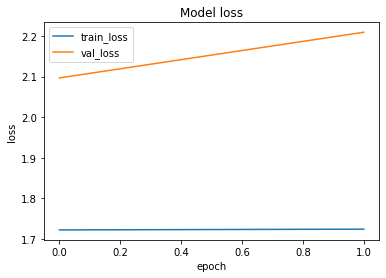

In [28]:
# plot the training artifacts

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'best')
plt.show()

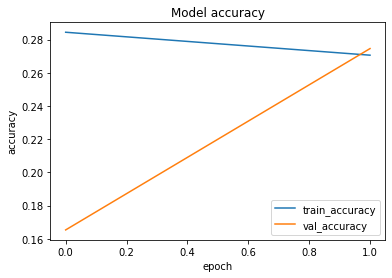

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'], loc = 'best')
plt.show()